<a href="https://colab.research.google.com/github/majdsuleiman98/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import shutil
import random
import os
import cv2
from keras.models import Sequential
from keras.layers import Dropout,Flatten,Dense,Conv2D
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [6]:
os.chdir("/content/drive/MyDrive/Brain_Tumor")
PATH = os.getcwd()

In [24]:
"""
this code for distribute images to (train,validation,test) folders

for CLASS in os.listdir("brain_tumor_dataset"):
  Number_Of_Images = len(os.listdir("brain_tumor_dataset/"+CLASS))
  for Number,Image in enumerate(os.listdir("brain_tumor_dataset/"+CLASS)):
    img = "brain_tumor_dataset/"+CLASS+"/"+Image
    if Number < 3 :
      shutil.copy(img,"TEST/"+CLASS.upper()+"/"+Image)
    elif Number < 0.8 * Number_Of_Images:
      shutil.copy(img,"TRAIN/"+CLASS.upper()+"/"+Image)
    else:
      shutil.copy(img,"VAL/"+CLASS.upper()+"/"+Image)

"""

In [7]:
#this function to draw distribution of images in datasets (TEST,TRAIN,VALIDATION)
def draw_distribution():
  distribution=dict()
  for folder in ["TEST","TRAIN","VAL"]:
    distribution[folder]=dict()
    for CLASS in os.listdir(folder):
      Number_Of_Images=len(os.listdir(folder+"/"+CLASS))
      distribution[folder][CLASS] = Number_Of_Images
      #print(f"found {Number_Of_Images} in {CLASS} in {folder}")
    plt.pie(distribution[folder].values(),labels=distribution[folder].keys(),autopct='%1.1f%%')
    title_text = f"{folder}: {distribution[folder]}"
    plt.title(title_text)
    plt.show()

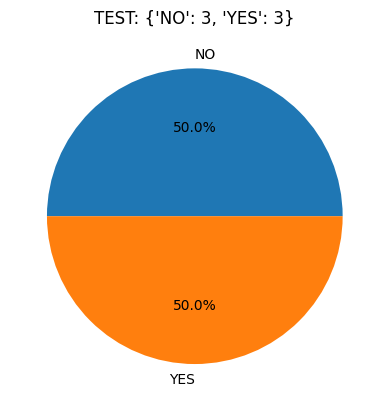

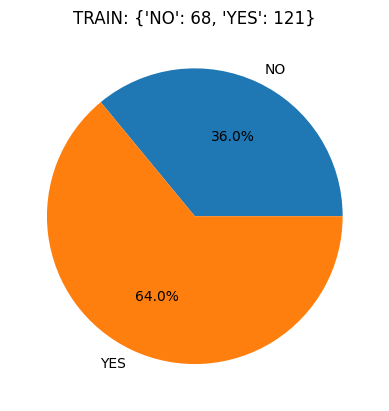

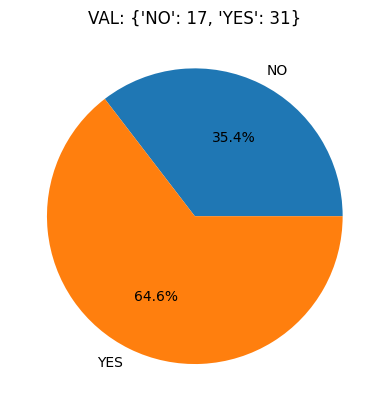

In [8]:
draw_distribution()

In [9]:
#this function to draw some images form datasets
def draw_images(dataset):
    num_images_per_class = 3
    plt.figure(figsize=(10,6))
    for CLASS in os.listdir(dataset):
        class_images = os.listdir(dataset+"/"+CLASS)
        if len(class_images) < num_images_per_class:
            continue
        for i in range(num_images_per_class):
            img = plt.imread(os.path.join(dataset, CLASS, class_images[i]))
            plt.subplot(2, num_images_per_class, i + 1 + num_images_per_class * (1 if "YES" in CLASS else 0))
            plt.imshow(img,cmap="gray")
            plt.axis("off")
            plt.title(CLASS)

    plt.show()

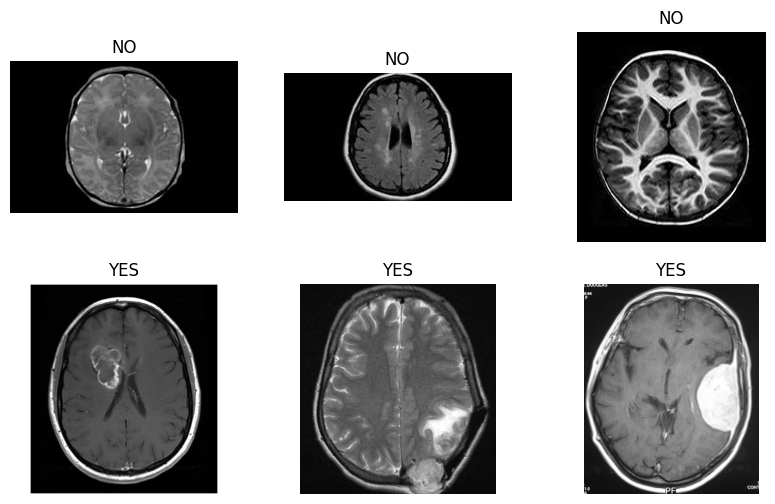

In [10]:
draw_images("TRAIN")

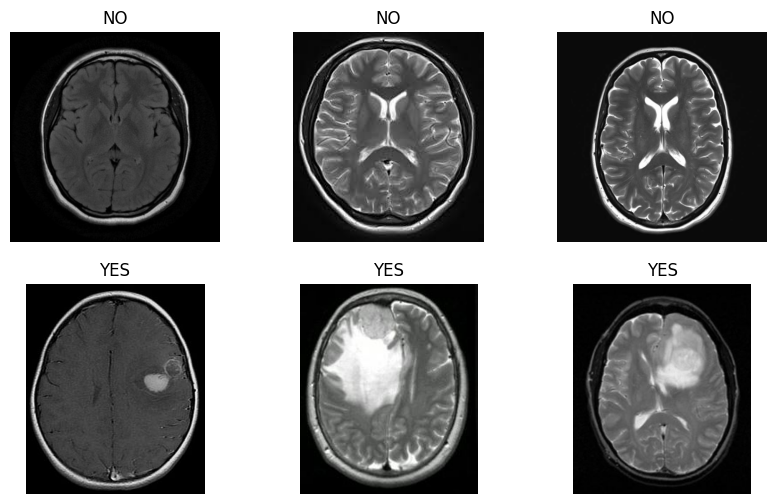

In [11]:
draw_images("VAL")

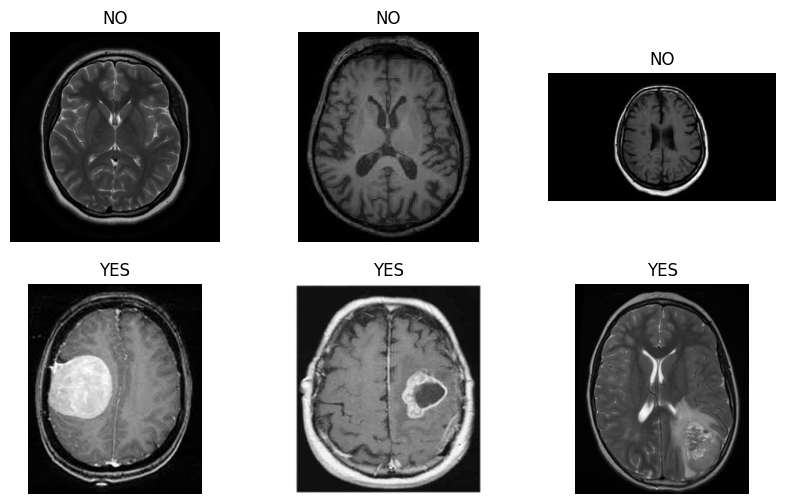

In [12]:
draw_images("TEST")

In [13]:
def Load_Data(path):
  X=list()
  y=list()
  labels=dict()
  i=0
  for CLASS in tqdm(os.listdir(path)):
    labels[i]=CLASS
    for file in os.listdir(path+"/"+CLASS):
      img = cv2.imread(path+"/"+CLASS+"/"+file)
      X.append(img)
      y.append(i)
    i+=1
  X=np.array(X)
  y=np.array(y)
  return X,y,labels

In [14]:
X_train,y_train,labels = Load_Data("TRAIN")
X_test,y_test,_ = Load_Data("TEST")
X_validation,y_validation,_ = Load_Data("VAL")

100%|██████████| 2/2 [00:37<00:00, 18.96s/it]
<ipython-input-13-3bb2534ef1c6>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X=np.array(X)
100%|██████████| 2/2 [00:24<00:00, 12.27s/it]


In [15]:
len(X_train),len(y_train),len(X_test),len(y_test),len(X_validation),len(y_validation)

(189, 189, 6, 6, 48, 48)

In [22]:
def crop_images(dataset):
  new_set=list()
  for image in dataset:
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray,(5,5),0)
    _,thresh = cv2.threshold(gray,45,255,cv2.THRESH_BINARY)
    thresh = cv2.erode(thresh,None,iterations=2)
    thresh = cv2.dilate(thresh,None,iterations=2)
    thresh = np.uint8(thresh)
    contours,_ = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    max_area = -1
    max_contour = None
    for contour in contours :
      area = cv2.contourArea(contour)
      if area > max_area:
        max_area = area
        max_contour = contour

    (x,y,w,h) = cv2.boundingRect(max_contour)
    new_img = image[y:y+h,x:x+w]
    new_set.append(new_img)

  return np.array(new_set)

In [23]:
X_train_crop = crop_images(X_train)
X_test_crop = crop_images(X_test)
X_validation_crop = crop_images(X_validation)

<ipython-input-22-eee6dd5678b7>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(new_set)


In [24]:
len(X_train_crop),len(X_test_crop),len(X_validation_crop)

(189, 6, 48)

In [54]:
def draw_crop_images(X,y):
  plt.figure(figsize=(10,6))
  for i,img in enumerate(random.sample(range(len(X)),6)):
    plt.subplot(2,3,i+1)
    plt.imshow(X[img])
    plt.title(labels[y[img]])
    plt.axis("off")

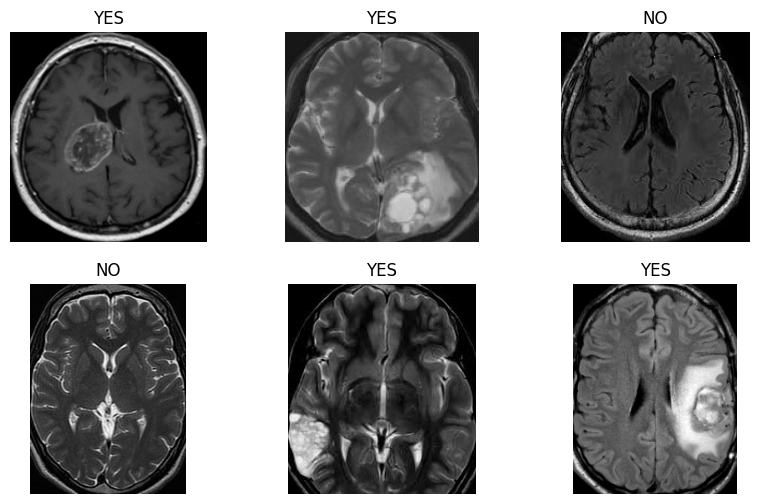

In [55]:
draw_crop_images(X_train_crop,y_train)

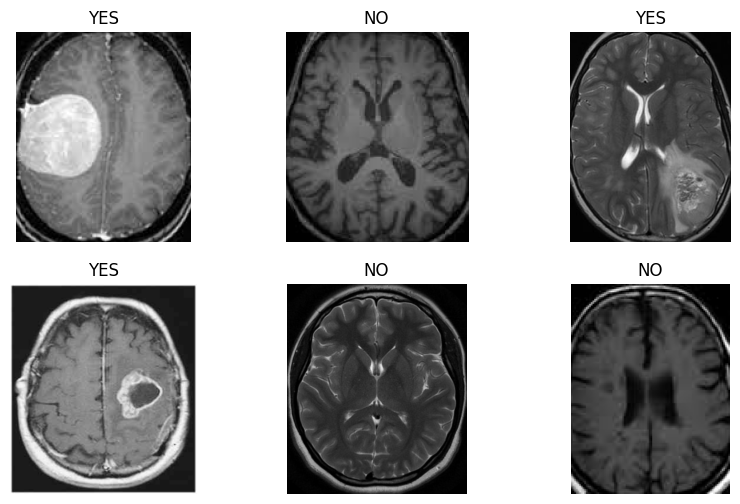

In [57]:
draw_crop_images(X_test_crop,y_test)

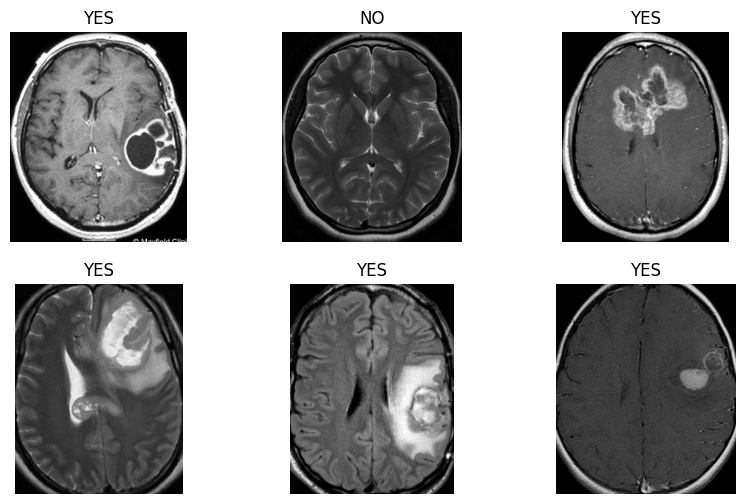

In [58]:
draw_crop_images(X_validation_crop,y_validation)

In [61]:
#this function to save croped images to folders (TRAIN_CROP,TEST_CROP,VAL_CROP)
def save_croped_images(X,y,folder_name):
  i=0
  for (image,CLASS) in zip(X,y):
    if CLASS == 0:
      cv2.imwrite(folder_name+"/NO/"+str(i)+".jpg",image)
    else:
      cv2.imwrite(folder_name+"/YES/"+str(i)+".jpg",image)
    i+=1

In [62]:
"""

save_croped_images(X_train_crop,y_train,"TRAIN_CROP")
save_croped_images(X_test_crop,y_test,"TEST_CROP")
save_croped_images(X_validation_crop,y_validation,"VAL_CROP")

"""

In [63]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5,1.5],
    vertical_flip=True,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [65]:
train = train_datagen.flow_from_directory(
    "TRAIN_CROP",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    seed=43
)

validation = validation_datagen.flow_from_directory(
    "VAL_CROP",
    target_size=(224,224),
    batch_size=16,
    class_mode="binary",
    seed=43
)

Found 189 images belonging to 2 classes.
Found 48 images belonging to 2 classes.


In [66]:
train.class_indices

{'NO': 0, 'YES': 1}

In [71]:
def draw_proccesed_images(dataset):
  plt.figure(figsize=(10,8))
  for i in range(12):
    plt.subplot(3,4,i+1)
    for x_batch,y_batch in dataset:
      img = x_batch[0]
      title = y_batch[0]
      plt.imshow(img)
      plt.title(labels[title])
      plt.axis("off")
      break

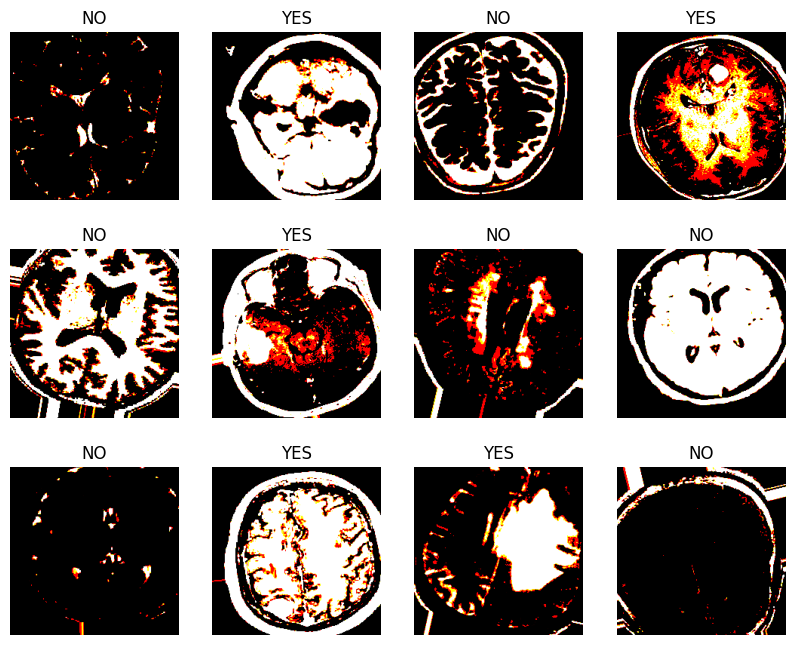

In [72]:
draw_proccesed_images(train)

In [73]:
vgg16 = VGG16(weights="imagenet",include_top=False,input_shape=(224,224,3))

58889256/58889256 [==============================] - 4s 0us/step


In [76]:
for layer in vgg16.layers:
  layer.trainable = False

In [77]:
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

In [78]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dropout_1 (Dropout)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [81]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

In [82]:
history = model.fit(train,validation_data=validation,epochs=20)

Epoch 1/20
6/6 [==============================] - 23s 2s/step - loss: 6.4775 - accuracy: 0.5291 - val_loss: 2.5381 - val_accuracy: 0.7917
Epoch 2/20
6/6 [==============================] - 5s 889ms/step - loss: 3.8295 - accuracy: 0.7249 - val_loss: 2.7945 - val_accuracy: 0.7708
Epoch 3/20
6/6 [==============================] - 4s 641ms/step - loss: 2.7561 - accuracy: 0.7460 - val_loss: 1.4047 - val_accuracy: 0.8542
Epoch 4/20
6/6 [==============================] - 4s 662ms/step - loss: 1.6793 - accuracy: 0.8148 - val_loss: 1.4778 - val_accuracy: 0.8542
Epoch 5/20
6/6 [==============================] - 5s 857ms/step - loss: 1.4980 - accuracy: 0.8624 - val_loss: 1.3671 - val_accuracy: 0.8542
Epoch 6/20
6/6 [==============================] - 5s 911ms/step - loss: 1.8784 - accuracy: 0.8254 - val_loss: 1.7670 - val_accuracy: 0.8333
Epoch 7/20
6/6 [==============================] - 5s 726ms/step - loss: 1.8144 - accuracy: 0.8624 - val_loss: 1.4235 - val_accuracy: 0.8333
Epoch 8/20
6/6 [======

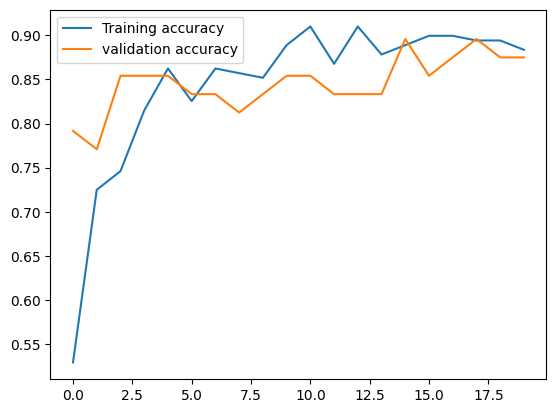

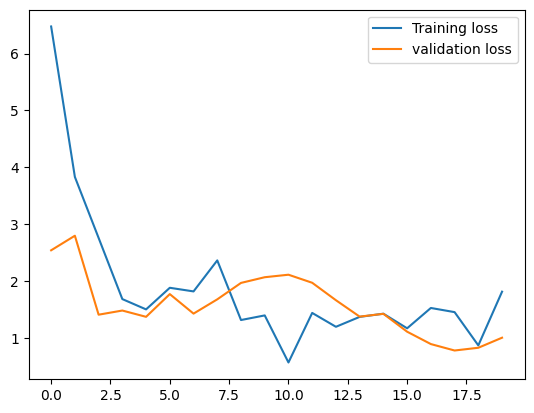

In [85]:
for i,met in enumerate(["accuracy","loss"]):
  plt.figure(i)
  plt.plot(history.history[met],label="Training "+met)
  plt.plot(history.history["val_"+met],label="validation "+met)
  plt.legend()

In [117]:
def predict_class(img_path):
  img = image.load_img(img_path,target_size=(224,224))
  img = image.img_to_array(img)
  img = np.expand_dims(img,axis=0)
  preprocessed_img = preprocess_input(img)

  prediction = model.predict(preprocessed_img)
  pred_class = 0 if prediction < 0.5 else 1

  imshow = plt.imread(img_path)
  plt.imshow(imshow)
  plt.title(labels[pred_class])
  plt.axis("off")
  plt.show()


1/1 [==============================] - 0s 75ms/step


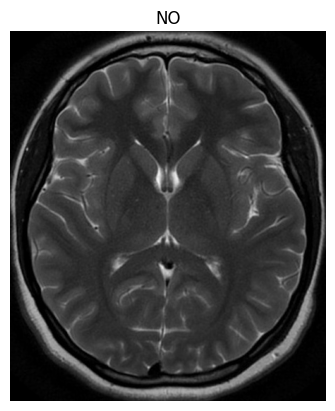

In [121]:
predict_class("TEST_CROP/NO/0.jpg")

1/1 [==============================] - 0s 35ms/step


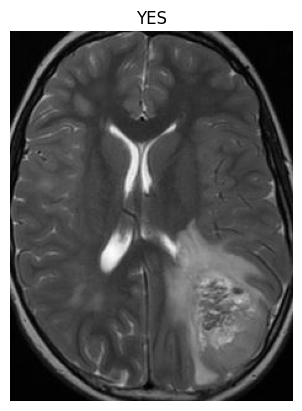

In [125]:
predict_class("TEST_CROP/YES/5.jpg")